## Importing Required Libraries

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg19 import VGG19
from keras.models import Model

## Extracting Files

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip -u "/content/gdrive/MyDrive/archive.zip" -d "/content"

In [5]:
c = '/content/COVID-19_Radiography_Dataset/COVID/images'
n = '/content/COVID-19_Radiography_Dataset/Normal/images'
#c = '/Users/xiaolai/Desktop/MScProject/COVID19_Radiography_Dataset/data/COVID/images'
#n = '/Users/xiaolai/Desktop/MScProject/COVID19_Radiography_Dataset/data/Normal/images'

In [6]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n), 4000) # random select 4000 images for Normal

### Classes
* 0 -> Normal

* 1 -> COVID

In [7]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(1))
    else:
        categories.append(str(0))

## Converting to Dataframe

In [8]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [9]:
df.head()

,filename,category
0,/content/COVID-19_Radiography_Dataset/COVID/im...,1
1,/content/COVID-19_Radiography_Dataset/COVID/im...,1
2,/content/COVID-19_Radiography_Dataset/COVID/im...,1
3,/content/COVID-19_Radiography_Dataset/COVID/im...,1
4,/content/COVID-19_Radiography_Dataset/COVID/im...,1


## Exploratory Data Analysis

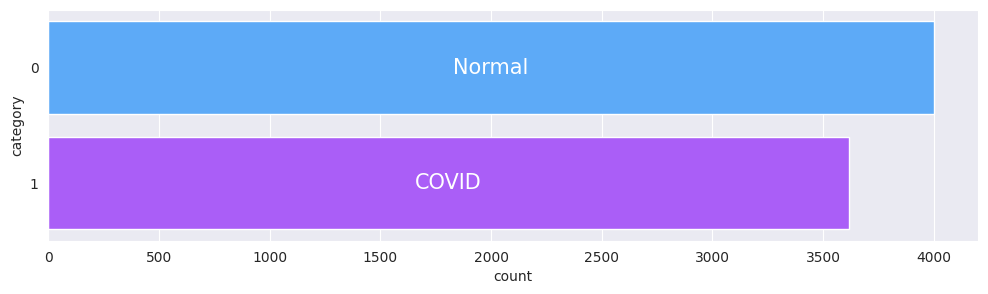

In [10]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = df.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels=['Normal', 'COVID'], 
              label_type='center', size=15, color='w')
plt.show()

## Data Visualization

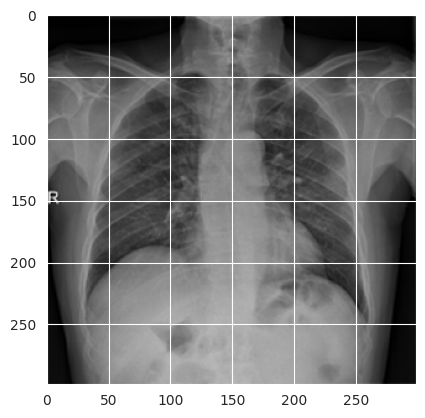

In [11]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

## Splitting Train, Validation & Test Data

In [12]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [13]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

## Data Augmentation

In [14]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [15]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 6092 validated image filenames belonging to 2 classes.


In [16]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

test_generator = valid_data_gen.flow_from_dataframe(
    test_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 762 validated image filenames belonging to 2 classes.
Found 762 validated image filenames belonging to 2 classes.


## Model Training - ResNet50

#### Model Architecture

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [17]:
baseModel = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

80134624/80134624 [==============================] - 1s 0us/step


#### Model Summary

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Optimizer - Adam

In [18]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
checkpoint = keras.callbacks.ModelCheckpoint("best_model",
                                            save_best_only=True)
#stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [20]:
epochs = 200
history = model.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs, callbacks=[checkpoint])

Epoch 1/200
407/407 [==============================] - ETA: 0s - loss: 0.5211 - accuracy: 0.7508

407/407 [==============================] - 117s 255ms/step - loss: 0.5211 - accuracy: 0.7508 - val_loss: 0.4234 - val_accuracy: 0.8045
Epoch 2/200
407/407 [==============================] - ETA: 0s - loss: 0.4440 - accuracy: 0.7955

407/407 [==============================] - 98s 242ms/step - loss: 0.4440 - accuracy: 0.7955 - val_loss: 0.3803 - val_accuracy: 0.8333
Epoch 3/200
407/407 [==============================] - ETA: 0s - loss: 0.4193 - accuracy: 0.8094

407/407 [==============================] - 98s 241ms/step - loss: 0.4193 - accuracy: 0.8094 - val_loss: 0.3730 - val_accuracy: 0.8281
Epoch 4/200
407/407 [==============================] - ETA: 0s - loss: 0.3952 - accuracy: 0.8227

407/407 [==============================] - 99s 244ms/step - loss: 0.3952 - accuracy: 0.8227 - val_loss: 0.3334 - val_accuracy: 0.8622
Epoch 5/200
407/407 [==============================] - ETA: 0s - loss: 0.3688 - accuracy: 0.8380

407/407 [==============================] - 96s 237ms/step - loss: 0.3688 - accuracy: 0.8380 - val_loss: 0.3254 - val_accuracy: 0.8675
Epoch 6/200
407/407 [==============================] - ETA: 0s - loss: 0.3609 - accuracy: 0.8404

407/407 [==============================] - 97s 239ms/step - loss: 0.3609 - accuracy: 0.8404 - val_loss: 0.3025 - val_accuracy: 0.8793
Epoch 7/200
407/407 [==============================] - ETA: 0s - loss: 0.3460 - accuracy: 0.8516

407/407 [==============================] - 97s 238ms/step - loss: 0.3460 - accuracy: 0.8516 - val_loss: 0.2779 - val_accuracy: 0.8950
Epoch 8/200
407/407 [==============================] - 94s 231ms/step - loss: 0.3367 - accuracy: 0.8533 - val_loss: 0.2990 - val_accuracy: 0.8793
Epoch 9/200
407/407 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.8580

407/407 [==============================] - 100s 244ms/step - loss: 0.3318 - accuracy: 0.8580 - val_loss: 0.2662 - val_accuracy: 0.8990
Epoch 10/200
407/407 [==============================] - ETA: 0s - loss: 0.3253 - accuracy: 0.8551

407/407 [==============================] - 97s 237ms/step - loss: 0.3253 - accuracy: 0.8551 - val_loss: 0.2564 - val_accuracy: 0.8924
Epoch 11/200
407/407 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.8644

407/407 [==============================] - 97s 239ms/step - loss: 0.3180 - accuracy: 0.8644 - val_loss: 0.2561 - val_accuracy: 0.9003
Epoch 12/200
407/407 [==============================] - 95s 233ms/step - loss: 0.3054 - accuracy: 0.8713 - val_loss: 0.3109 - val_accuracy: 0.8504
Epoch 13/200
407/407 [==============================] - ETA: 0s - loss: 0.3076 - accuracy: 0.8718

407/407 [==============================] - 97s 239ms/step - loss: 0.3076 - accuracy: 0.8718 - val_loss: 0.2356 - val_accuracy: 0.8976
Epoch 14/200
407/407 [==============================] - 95s 232ms/step - loss: 0.2971 - accuracy: 0.8754 - val_loss: 0.2512 - val_accuracy: 0.8898
Epoch 15/200
407/407 [==============================] - 93s 228ms/step - loss: 0.2882 - accuracy: 0.8793 - val_loss: 0.2366 - val_accuracy: 0.9055
Epoch 16/200
407/407 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.8826

407/407 [==============================] - 97s 238ms/step - loss: 0.2819 - accuracy: 0.8826 - val_loss: 0.2336 - val_accuracy: 0.8937
Epoch 17/200
407/407 [==============================] - 95s 232ms/step - loss: 0.2864 - accuracy: 0.8787 - val_loss: 0.2359 - val_accuracy: 0.9147
Epoch 18/200
407/407 [==============================] - ETA: 0s - loss: 0.2693 - accuracy: 0.8908

407/407 [==============================] - 95s 234ms/step - loss: 0.2693 - accuracy: 0.8908 - val_loss: 0.2239 - val_accuracy: 0.9173
Epoch 19/200
407/407 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.8756

407/407 [==============================] - 97s 238ms/step - loss: 0.2796 - accuracy: 0.8756 - val_loss: 0.2203 - val_accuracy: 0.9121
Epoch 20/200
407/407 [==============================] - 94s 231ms/step - loss: 0.2697 - accuracy: 0.8851 - val_loss: 0.2280 - val_accuracy: 0.9029
Epoch 21/200
407/407 [==============================] - 94s 231ms/step - loss: 0.2651 - accuracy: 0.8871 - val_loss: 0.2375 - val_accuracy: 0.9016
Epoch 22/200
407/407 [==============================] - 98s 240ms/step - loss: 0.2676 - accuracy: 0.8894 - val_loss: 0.2251 - val_accuracy: 0.9239
Epoch 23/200
407/407 [==============================] - ETA: 0s - loss: 0.2674 - accuracy: 0.8874

407/407 [==============================] - 96s 236ms/step - loss: 0.2674 - accuracy: 0.8874 - val_loss: 0.2112 - val_accuracy: 0.9252
Epoch 24/200
407/407 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.8859

407/407 [==============================] - 96s 236ms/step - loss: 0.2686 - accuracy: 0.8859 - val_loss: 0.2048 - val_accuracy: 0.9068
Epoch 25/200
407/407 [==============================] - 94s 232ms/step - loss: 0.2601 - accuracy: 0.8864 - val_loss: 0.2070 - val_accuracy: 0.9186
Epoch 26/200
407/407 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.8987

407/407 [==============================] - 97s 239ms/step - loss: 0.2506 - accuracy: 0.8987 - val_loss: 0.1995 - val_accuracy: 0.9160
Epoch 27/200
407/407 [==============================] - 95s 233ms/step - loss: 0.2634 - accuracy: 0.8884 - val_loss: 0.2040 - val_accuracy: 0.9213
Epoch 28/200
407/407 [==============================] - 94s 232ms/step - loss: 0.2530 - accuracy: 0.8946 - val_loss: 0.2114 - val_accuracy: 0.9173
Epoch 29/200
407/407 [==============================] - 94s 231ms/step - loss: 0.2449 - accuracy: 0.8959 - val_loss: 0.2241 - val_accuracy: 0.8911
Epoch 30/200
407/407 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.8971

407/407 [==============================] - 97s 238ms/step - loss: 0.2466 - accuracy: 0.8971 - val_loss: 0.1907 - val_accuracy: 0.9186
Epoch 31/200
407/407 [==============================] - 95s 233ms/step - loss: 0.2425 - accuracy: 0.9005 - val_loss: 0.1982 - val_accuracy: 0.9213
Epoch 32/200
407/407 [==============================] - 93s 229ms/step - loss: 0.2356 - accuracy: 0.8992 - val_loss: 0.2303 - val_accuracy: 0.9147
Epoch 33/200
407/407 [==============================] - 94s 229ms/step - loss: 0.2420 - accuracy: 0.9000 - val_loss: 0.1997 - val_accuracy: 0.9265
Epoch 34/200
407/407 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.8961

407/407 [==============================] - 96s 236ms/step - loss: 0.2428 - accuracy: 0.8961 - val_loss: 0.1857 - val_accuracy: 0.9278
Epoch 35/200
407/407 [==============================] - 93s 229ms/step - loss: 0.2454 - accuracy: 0.8941 - val_loss: 0.1905 - val_accuracy: 0.9160
Epoch 36/200
407/407 [==============================] - 93s 228ms/step - loss: 0.2328 - accuracy: 0.9041 - val_loss: 0.1917 - val_accuracy: 0.9304
Epoch 37/200
407/407 [==============================] - 94s 230ms/step - loss: 0.2324 - accuracy: 0.9038 - val_loss: 0.1895 - val_accuracy: 0.9291
Epoch 38/200
407/407 [==============================] - 94s 232ms/step - loss: 0.2244 - accuracy: 0.9053 - val_loss: 0.2035 - val_accuracy: 0.9173
Epoch 39/200
407/407 [==============================] - 93s 229ms/step - loss: 0.2320 - accuracy: 0.9035 - val_loss: 0.1913 - val_accuracy: 0.9199
Epoch 40/200
407/407 [==============================] - 93s 229ms/step - loss: 0.2184 - accuracy: 0.9091 - val_loss: 0.1892 - val_a

407/407 [==============================] - 97s 239ms/step - loss: 0.2250 - accuracy: 0.9061 - val_loss: 0.1833 - val_accuracy: 0.9278
Epoch 42/200
407/407 [==============================] - 94s 232ms/step - loss: 0.2295 - accuracy: 0.9022 - val_loss: 0.1866 - val_accuracy: 0.9304
Epoch 43/200
407/407 [==============================] - ETA: 0s - loss: 0.2271 - accuracy: 0.9033

407/407 [==============================] - 96s 236ms/step - loss: 0.2271 - accuracy: 0.9033 - val_loss: 0.1743 - val_accuracy: 0.9344
Epoch 44/200
407/407 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9050

407/407 [==============================] - 97s 238ms/step - loss: 0.2244 - accuracy: 0.9050 - val_loss: 0.1684 - val_accuracy: 0.9304
Epoch 45/200
407/407 [==============================] - 92s 225ms/step - loss: 0.2174 - accuracy: 0.9087 - val_loss: 0.1783 - val_accuracy: 0.9304
Epoch 46/200
407/407 [==============================] - 91s 223ms/step - loss: 0.2159 - accuracy: 0.9109 - val_loss: 0.1812 - val_accuracy: 0.9318
Epoch 47/200
407/407 [==============================] - 91s 223ms/step - loss: 0.2156 - accuracy: 0.9074 - val_loss: 0.1750 - val_accuracy: 0.9278
Epoch 48/200
407/407 [==============================] - ETA: 0s - loss: 0.2176 - accuracy: 0.9073

407/407 [==============================] - 92s 226ms/step - loss: 0.2176 - accuracy: 0.9073 - val_loss: 0.1682 - val_accuracy: 0.9409
Epoch 49/200
407/407 [==============================] - 92s 225ms/step - loss: 0.2162 - accuracy: 0.9110 - val_loss: 0.1777 - val_accuracy: 0.9304
Epoch 50/200
407/407 [==============================] - ETA: 0s - loss: 0.2106 - accuracy: 0.9133

407/407 [==============================] - 93s 229ms/step - loss: 0.2106 - accuracy: 0.9133 - val_loss: 0.1638 - val_accuracy: 0.9252
Epoch 51/200
407/407 [==============================] - ETA: 0s - loss: 0.2057 - accuracy: 0.9114

407/407 [==============================] - 93s 229ms/step - loss: 0.2057 - accuracy: 0.9114 - val_loss: 0.1577 - val_accuracy: 0.9344
Epoch 52/200
407/407 [==============================] - 91s 224ms/step - loss: 0.2107 - accuracy: 0.9107 - val_loss: 0.1624 - val_accuracy: 0.9409
Epoch 53/200
407/407 [==============================] - 90s 221ms/step - loss: 0.2108 - accuracy: 0.9137 - val_loss: 0.1793 - val_accuracy: 0.9318
Epoch 54/200
407/407 [==============================] - 90s 221ms/step - loss: 0.2046 - accuracy: 0.9146 - val_loss: 0.1599 - val_accuracy: 0.9331
Epoch 55/200
407/407 [==============================] - 91s 223ms/step - loss: 0.2039 - accuracy: 0.9155 - val_loss: 0.2243 - val_accuracy: 0.9094
Epoch 56/200
407/407 [==============================] - 90s 221ms/step - loss: 0.2076 - accuracy: 0.9168 - val_loss: 0.1594 - val_accuracy: 0.9383
Epoch 57/200
407/407 [==============================] - 90s 220ms/step - loss: 0.2059 - accuracy: 0.9148 - val_loss: 0.1815 - val_a

407/407 [==============================] - 92s 225ms/step - loss: 0.2017 - accuracy: 0.9176 - val_loss: 0.1546 - val_accuracy: 0.9396
Epoch 63/200
407/407 [==============================] - 93s 229ms/step - loss: 0.2022 - accuracy: 0.9148 - val_loss: 0.1723 - val_accuracy: 0.9357
Epoch 64/200
407/407 [==============================] - 96s 237ms/step - loss: 0.1971 - accuracy: 0.9184 - val_loss: 0.1576 - val_accuracy: 0.9423
Epoch 65/200
407/407 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 0.9160

407/407 [==============================] - 95s 232ms/step - loss: 0.2036 - accuracy: 0.9160 - val_loss: 0.1505 - val_accuracy: 0.9475
Epoch 66/200
407/407 [==============================] - 90s 220ms/step - loss: 0.2047 - accuracy: 0.9148 - val_loss: 0.2558 - val_accuracy: 0.8963
Epoch 67/200
407/407 [==============================] - 90s 220ms/step - loss: 0.1936 - accuracy: 0.9210 - val_loss: 0.1581 - val_accuracy: 0.9370
Epoch 68/200
407/407 [==============================] - 90s 222ms/step - loss: 0.1977 - accuracy: 0.9184 - val_loss: 0.1720 - val_accuracy: 0.9331
Epoch 69/200
407/407 [==============================] - 89s 218ms/step - loss: 0.1958 - accuracy: 0.9217 - val_loss: 0.1617 - val_accuracy: 0.9370
Epoch 70/200
407/407 [==============================] - 90s 220ms/step - loss: 0.1904 - accuracy: 0.9235 - val_loss: 0.1636 - val_accuracy: 0.9396
Epoch 71/200
407/407 [==============================] - 89s 218ms/step - loss: 0.1910 - accuracy: 0.9215 - val_loss: 0.1757 - val_a

407/407 [==============================] - 97s 237ms/step - loss: 0.1881 - accuracy: 0.9240 - val_loss: 0.1484 - val_accuracy: 0.9449
Epoch 76/200
407/407 [==============================] - 97s 238ms/step - loss: 0.1933 - accuracy: 0.9250 - val_loss: 0.1553 - val_accuracy: 0.9436
Epoch 77/200
407/407 [==============================] - ETA: 0s - loss: 0.1810 - accuracy: 0.9248

407/407 [==============================] - 96s 236ms/step - loss: 0.1810 - accuracy: 0.9248 - val_loss: 0.1461 - val_accuracy: 0.9514
Epoch 78/200
407/407 [==============================] - 89s 219ms/step - loss: 0.1775 - accuracy: 0.9289 - val_loss: 0.1582 - val_accuracy: 0.9409
Epoch 79/200
407/407 [==============================] - 88s 216ms/step - loss: 0.1786 - accuracy: 0.9247 - val_loss: 0.1696 - val_accuracy: 0.9278
Epoch 80/200
407/407 [==============================] - 88s 215ms/step - loss: 0.1818 - accuracy: 0.9263 - val_loss: 0.1480 - val_accuracy: 0.9475
Epoch 81/200
407/407 [==============================] - 88s 215ms/step - loss: 0.1788 - accuracy: 0.9261 - val_loss: 0.1514 - val_accuracy: 0.9501
Epoch 82/200
407/407 [==============================] - 88s 216ms/step - loss: 0.1878 - accuracy: 0.9265 - val_loss: 0.1704 - val_accuracy: 0.9344
Epoch 83/200
407/407 [==============================] - 88s 215ms/step - loss: 0.1834 - accuracy: 0.9238 - val_loss: 0.2169 - val_a

407/407 [==============================] - 91s 223ms/step - loss: 0.1782 - accuracy: 0.9291 - val_loss: 0.1407 - val_accuracy: 0.9501
Epoch 86/200
407/407 [==============================] - 90s 221ms/step - loss: 0.1741 - accuracy: 0.9284 - val_loss: 0.1472 - val_accuracy: 0.9436
Epoch 87/200
407/407 [==============================] - 90s 222ms/step - loss: 0.1733 - accuracy: 0.9319 - val_loss: 0.1475 - val_accuracy: 0.9475
Epoch 88/200
407/407 [==============================] - 90s 222ms/step - loss: 0.1782 - accuracy: 0.9261 - val_loss: 0.1735 - val_accuracy: 0.9370
Epoch 89/200
407/407 [==============================] - 90s 222ms/step - loss: 0.1783 - accuracy: 0.9255 - val_loss: 0.1642 - val_accuracy: 0.9409
Epoch 90/200
407/407 [==============================] - 93s 228ms/step - loss: 0.1683 - accuracy: 0.9325 - val_loss: 0.1739 - val_accuracy: 0.9357
Epoch 91/200
407/407 [==============================] - 93s 229ms/step - loss: 0.1673 - accuracy: 0.9324 - val_loss: 0.1823 - val_a

407/407 [==============================] - 95s 233ms/step - loss: 0.1695 - accuracy: 0.9329 - val_loss: 0.1398 - val_accuracy: 0.9436
Epoch 96/200
407/407 [==============================] - ETA: 0s - loss: 0.1651 - accuracy: 0.9329

407/407 [==============================] - 96s 237ms/step - loss: 0.1651 - accuracy: 0.9329 - val_loss: 0.1363 - val_accuracy: 0.9436
Epoch 97/200
407/407 [==============================] - 92s 226ms/step - loss: 0.1668 - accuracy: 0.9319 - val_loss: 0.1440 - val_accuracy: 0.9462
Epoch 98/200
407/407 [==============================] - 92s 227ms/step - loss: 0.1653 - accuracy: 0.9345 - val_loss: 0.1445 - val_accuracy: 0.9423
Epoch 99/200
407/407 [==============================] - ETA: 0s - loss: 0.1725 - accuracy: 0.9268

407/407 [==============================] - 95s 233ms/step - loss: 0.1725 - accuracy: 0.9268 - val_loss: 0.1363 - val_accuracy: 0.9475
Epoch 100/200
407/407 [==============================] - 90s 221ms/step - loss: 0.1729 - accuracy: 0.9288 - val_loss: 0.1446 - val_accuracy: 0.9436
Epoch 101/200
407/407 [==============================] - 89s 219ms/step - loss: 0.1651 - accuracy: 0.9330 - val_loss: 0.1478 - val_accuracy: 0.9409
Epoch 102/200
407/407 [==============================] - 91s 224ms/step - loss: 0.1706 - accuracy: 0.9286 - val_loss: 0.1417 - val_accuracy: 0.9567
Epoch 103/200
407/407 [==============================] - ETA: 0s - loss: 0.1706 - accuracy: 0.9294

407/407 [==============================] - 95s 233ms/step - loss: 0.1706 - accuracy: 0.9294 - val_loss: 0.1356 - val_accuracy: 0.9501
Epoch 104/200
407/407 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9319

407/407 [==============================] - 92s 227ms/step - loss: 0.1658 - accuracy: 0.9319 - val_loss: 0.1310 - val_accuracy: 0.9554
Epoch 105/200
407/407 [==============================] - 92s 226ms/step - loss: 0.1597 - accuracy: 0.9365 - val_loss: 0.1358 - val_accuracy: 0.9488
Epoch 106/200
407/407 [==============================] - 90s 221ms/step - loss: 0.1564 - accuracy: 0.9371 - val_loss: 0.1407 - val_accuracy: 0.9449
Epoch 107/200
407/407 [==============================] - 96s 235ms/step - loss: 0.1688 - accuracy: 0.9306 - val_loss: 0.1565 - val_accuracy: 0.9383
Epoch 108/200
407/407 [==============================] - 112s 276ms/step - loss: 0.1679 - accuracy: 0.9286 - val_loss: 0.1654 - val_accuracy: 0.9344
Epoch 109/200
407/407 [==============================] - 104s 256ms/step - loss: 0.1584 - accuracy: 0.9368 - val_loss: 0.1415 - val_accuracy: 0.9475
Epoch 110/200
407/407 [==============================] - 91s 224ms/step - loss: 0.1600 - accuracy: 0.9355 - val_loss: 0.1327

407/407 [==============================] - 95s 234ms/step - loss: 0.1446 - accuracy: 0.9429 - val_loss: 0.1299 - val_accuracy: 0.9475
Epoch 137/200
407/407 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.9404

407/407 [==============================] - 95s 233ms/step - loss: 0.1492 - accuracy: 0.9404 - val_loss: 0.1217 - val_accuracy: 0.9501
Epoch 138/200
407/407 [==============================] - 92s 225ms/step - loss: 0.1407 - accuracy: 0.9417 - val_loss: 0.1405 - val_accuracy: 0.9449
Epoch 139/200
407/407 [==============================] - 91s 225ms/step - loss: 0.1519 - accuracy: 0.9406 - val_loss: 0.1418 - val_accuracy: 0.9423
Epoch 140/200
407/407 [==============================] - 90s 220ms/step - loss: 0.1448 - accuracy: 0.9396 - val_loss: 0.1315 - val_accuracy: 0.9488
Epoch 141/200
407/407 [==============================] - 92s 225ms/step - loss: 0.1480 - accuracy: 0.9407 - val_loss: 0.1715 - val_accuracy: 0.9291
Epoch 142/200
407/407 [==============================] - 92s 227ms/step - loss: 0.1439 - accuracy: 0.9416 - val_loss: 0.1467 - val_accuracy: 0.9449
Epoch 143/200
407/407 [==============================] - 93s 228ms/step - loss: 0.1508 - accuracy: 0.9419 - val_loss: 0.1280 -

407/407 [==============================] - 93s 228ms/step - loss: 0.1415 - accuracy: 0.9424 - val_loss: 0.1159 - val_accuracy: 0.9580
Epoch 159/200
407/407 [==============================] - 91s 224ms/step - loss: 0.1417 - accuracy: 0.9434 - val_loss: 0.1247 - val_accuracy: 0.9593
Epoch 160/200
407/407 [==============================] - 96s 235ms/step - loss: 0.1364 - accuracy: 0.9442 - val_loss: 0.1541 - val_accuracy: 0.9423
Epoch 161/200
407/407 [==============================] - 98s 241ms/step - loss: 0.1419 - accuracy: 0.9429 - val_loss: 0.1249 - val_accuracy: 0.9580
Epoch 162/200
407/407 [==============================] - 95s 233ms/step - loss: 0.1429 - accuracy: 0.9455 - val_loss: 0.1203 - val_accuracy: 0.9659
Epoch 163/200
407/407 [==============================] - 95s 233ms/step - loss: 0.1327 - accuracy: 0.9458 - val_loss: 0.1197 - val_accuracy: 0.9541
Epoch 164/200
407/407 [==============================] - 92s 226ms/step - loss: 0.1331 - accuracy: 0.9468 - val_loss: 0.1161 -

407/407 [==============================] - 94s 231ms/step - loss: 0.1265 - accuracy: 0.9489 - val_loss: 0.1136 - val_accuracy: 0.9593
Epoch 182/200
407/407 [==============================] - 91s 224ms/step - loss: 0.1313 - accuracy: 0.9471 - val_loss: 0.1235 - val_accuracy: 0.9514
Epoch 183/200
407/407 [==============================] - 91s 223ms/step - loss: 0.1259 - accuracy: 0.9491 - val_loss: 0.1271 - val_accuracy: 0.9514
Epoch 184/200
407/407 [==============================] - 92s 225ms/step - loss: 0.1281 - accuracy: 0.9496 - val_loss: 0.1297 - val_accuracy: 0.9475
Epoch 185/200
407/407 [==============================] - 91s 223ms/step - loss: 0.1323 - accuracy: 0.9463 - val_loss: 0.1261 - val_accuracy: 0.9528
Epoch 186/200
407/407 [==============================] - 90s 220ms/step - loss: 0.1208 - accuracy: 0.9496 - val_loss: 0.1204 - val_accuracy: 0.9580
Epoch 187/200
407/407 [==============================] - 91s 223ms/step - loss: 0.1259 - accuracy: 0.9494 - val_loss: 0.1239 -

407/407 [==============================] - 94s 231ms/step - loss: 0.1239 - accuracy: 0.9544 - val_loss: 0.1119 - val_accuracy: 0.9606
Epoch 192/200
407/407 [==============================] - 91s 223ms/step - loss: 0.1215 - accuracy: 0.9529 - val_loss: 0.1160 - val_accuracy: 0.9619
Epoch 193/200
407/407 [==============================] - 90s 222ms/step - loss: 0.1122 - accuracy: 0.9554 - val_loss: 0.1265 - val_accuracy: 0.9528
Epoch 194/200
407/407 [==============================] - 91s 223ms/step - loss: 0.1284 - accuracy: 0.9496 - val_loss: 0.1634 - val_accuracy: 0.9357
Epoch 195/200
407/407 [==============================] - ETA: 0s - loss: 0.1307 - accuracy: 0.9476

407/407 [==============================] - 94s 231ms/step - loss: 0.1307 - accuracy: 0.9476 - val_loss: 0.1097 - val_accuracy: 0.9580
Epoch 196/200
407/407 [==============================] - 91s 224ms/step - loss: 0.1293 - accuracy: 0.9499 - val_loss: 0.1414 - val_accuracy: 0.9436
Epoch 197/200
407/407 [==============================] - 91s 222ms/step - loss: 0.1249 - accuracy: 0.9496 - val_loss: 0.1165 - val_accuracy: 0.9567
Epoch 198/200
407/407 [==============================] - 90s 220ms/step - loss: 0.1178 - accuracy: 0.9531 - val_loss: 0.1644 - val_accuracy: 0.9370
Epoch 199/200
407/407 [==============================] - 92s 225ms/step - loss: 0.1225 - accuracy: 0.9514 - val_loss: 0.1472 - val_accuracy: 0.9501
Epoch 200/200
407/407 [==============================] - 93s 228ms/step - loss: 0.1286 - accuracy: 0.9517 - val_loss: 0.1242 - val_accuracy: 0.9554


## Saving Model

In [21]:
model.save('/Users/xiaolai/Desktop/MScProject/VGG19_11042023.h5')

In [22]:
#import shutil
%cp -av "/content/best_model" "/content/gdrive/MyDrive/VGG19/"

'/content/best_model' -> '/content/gdrive/MyDrive/VGG19/best_model'
'/content/best_model/variables' -> '/content/gdrive/MyDrive/VGG19/best_model/variables'
'/content/best_model/variables/variables.index' -> '/content/gdrive/MyDrive/VGG19/best_model/variables/variables.index'
'/content/best_model/variables/variables.data-00000-of-00001' -> '/content/gdrive/MyDrive/VGG19/best_model/variables/variables.data-00000-of-00001'
'/content/best_model/assets' -> '/content/gdrive/MyDrive/VGG19/best_model/assets'
'/content/best_model/saved_model.pb' -> '/content/gdrive/MyDrive/VGG19/best_model/saved_model.pb'
'/content/best_model/keras_metadata.pb' -> '/content/gdrive/MyDrive/VGG19/best_model/keras_metadata.pb'
'/content/best_model/fingerprint.pb' -> '/content/gdrive/MyDrive/VGG19/best_model/fingerprint.pb'


## Model Evaluation


In [23]:
model.evaluate(train_generator)
model.evaluate(valid_generator)


51/51 [==============================] - 4s 79ms/step - loss: 0.1242 - accuracy: 0.9554


[0.1242162436246872, 0.9553805589675903]

In [24]:
# create history loss and accuracy function
def plot_loss_acc(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(train_loss))

    plt.figure(figsize=(8,6))
    plt.plot(epochs, train_loss, color='b', label='Train')
    plt.plot(epochs, val_loss, color='r', label='Validation')
    plt.legend()
    plt.title('Model Loss')
    
    
    plt.figure(figsize=(8,6))
    plt.plot(epochs, acc, color='b', label='Train')
    plt.plot(epochs, val_acc, color='r', label='Validation')
    plt.legend()
    plt.title('Model Accuracy')
    
    plt.show()

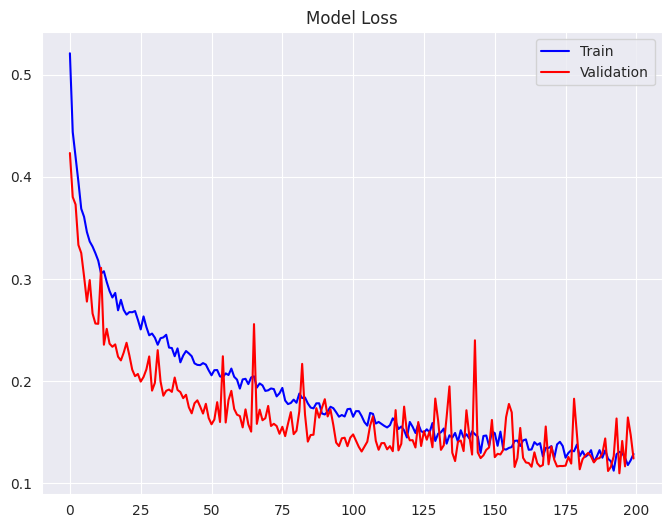

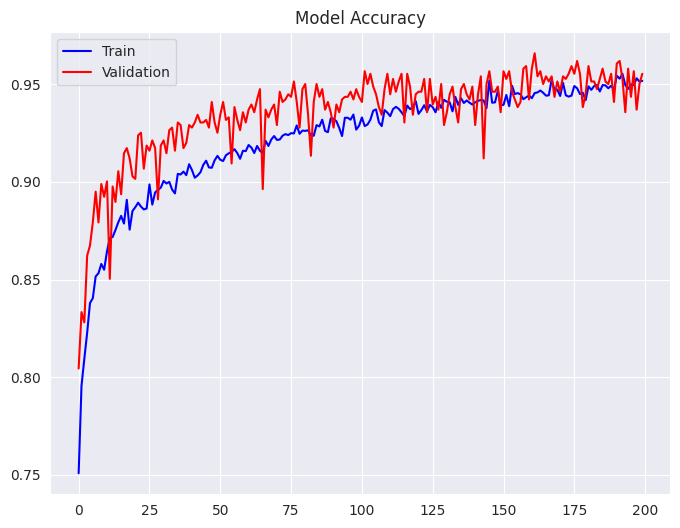

In [25]:
plot_loss_acc(history)

## Classificaiton Confusion Matrix

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [27]:
# predict classes of validation dataset
test_predict = model.predict(test_generator)

51/51 [==============================] - 4s 78ms/step


In [28]:
predict_class = np.argmax(test_predict, axis=1)
predict_class = predict_class.tolist()

In [29]:
labels = ['COVID', 'Normal']
report = classification_report(test_generator.classes, predict_class, target_names=labels)
print(report)

              precision    recall  f1-score   support

       COVID       0.53      0.54      0.53       400
      Normal       0.48      0.46      0.47       362

    accuracy                           0.50       762
   macro avg       0.50      0.50      0.50       762
weighted avg       0.50      0.50      0.50       762



In [30]:
cm = confusion_matrix(test_generator.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['COVID','NORMAL'], 
                     columns = ['COVID','NORMAL'])

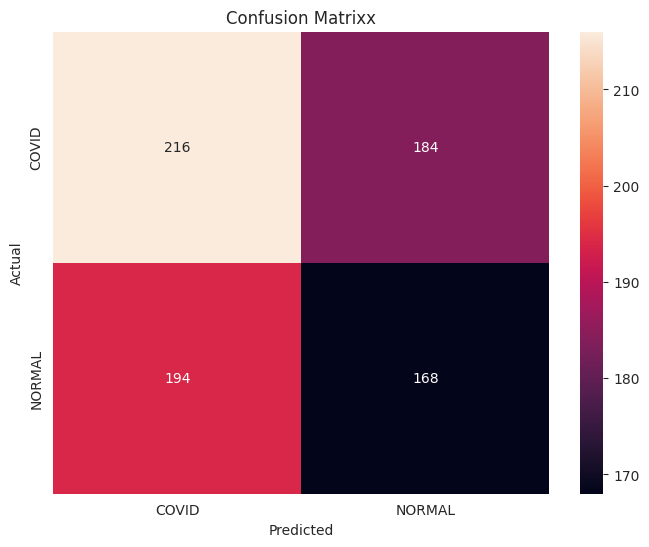

In [31]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Test External data

In [33]:
random.seed(42)
c2 = '/content/gdrive/MyDrive/dataset/COVID'
filenames2 = os.listdir(c2)

categories = []
for filename in filenames2:
    category = filename.split('-')[0]
    categories.append(str(1))


for i in range(len(filenames2)):
      filenames2[i] = os.path.join(c2, filenames2[i])
    
    
df2 = pd.DataFrame({
    'filename': filenames2,
    'category': categories
})

In [34]:
random.seed(42)
n2 = '/content/gdrive/MyDrive/dataset/Normal'
filenames3 = os.listdir(n2)

categories = []
for filename in filenames3:
    category = filename.split('-')[0]
    categories.append(str(0))


for i in range(len(filenames3)):
      filenames3[i] = os.path.join(n2, filenames3[i])
    
    
df3 = pd.DataFrame({
    'filename': filenames3,
    'category': categories
})

In [35]:
df2.head()

,filename,category
0,/content/gdrive/MyDrive/dataset/COVID/covid (3...,1
1,/content/gdrive/MyDrive/dataset/COVID/covid (1...,1
2,/content/gdrive/MyDrive/dataset/COVID/covid (1...,1
3,/content/gdrive/MyDrive/dataset/COVID/covid (3...,1
4,/content/gdrive/MyDrive/dataset/COVID/covid (2...,1


In [36]:
df3.head()

,filename,category
0,/content/gdrive/MyDrive/dataset/Normal/IM-0238...,0
1,/content/gdrive/MyDrive/dataset/Normal/IM-0222...,0
2,/content/gdrive/MyDrive/dataset/Normal/IM-0256...,0
3,/content/gdrive/MyDrive/dataset/Normal/IM-0214...,0
4,/content/gdrive/MyDrive/dataset/Normal/IM-0235...,0


In [37]:
frames = [df2, df3]

test2 = pd.concat(frames)

In [38]:
test2.head()

,filename,category
0,/content/gdrive/MyDrive/dataset/COVID/covid (3...,1
1,/content/gdrive/MyDrive/dataset/COVID/covid (1...,1
2,/content/gdrive/MyDrive/dataset/COVID/covid (1...,1
3,/content/gdrive/MyDrive/dataset/COVID/covid (3...,1
4,/content/gdrive/MyDrive/dataset/COVID/covid (2...,1


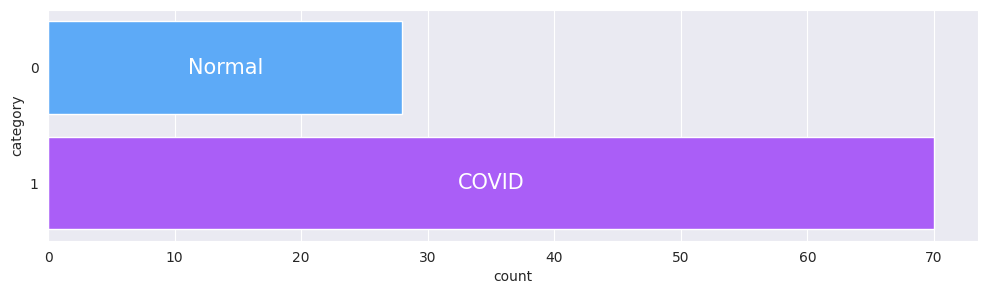

In [39]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = test2.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels=['Normal', 'COVID'], 
              label_type='center', size=15, color='w')
plt.show()

In [40]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

test2_generator = valid_data_gen.flow_from_dataframe(
    test2, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 98 validated image filenames belonging to 2 classes.


## Classificaiton Confusion Matrix

In [41]:
# predict classes of validation dataset
test_predict = model.predict(test2_generator)

7/7 [==============================] - 22s 4s/step


In [42]:
predict_class = np.argmax(test_predict, axis=1)
predict_class = predict_class.tolist()

In [43]:
labels = ['COVID', 'Normal']
report = classification_report(test2_generator.classes, predict_class, target_names=labels)
print(report)

              precision    recall  f1-score   support

       COVID       0.32      0.36      0.34        28
      Normal       0.73      0.70      0.72        70

    accuracy                           0.60        98
   macro avg       0.53      0.53      0.53        98
weighted avg       0.61      0.60      0.61        98



In [44]:
cm = confusion_matrix(test2_generator.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['COVID','NORMAL'], 
                     columns = ['COVID','NORMAL'])

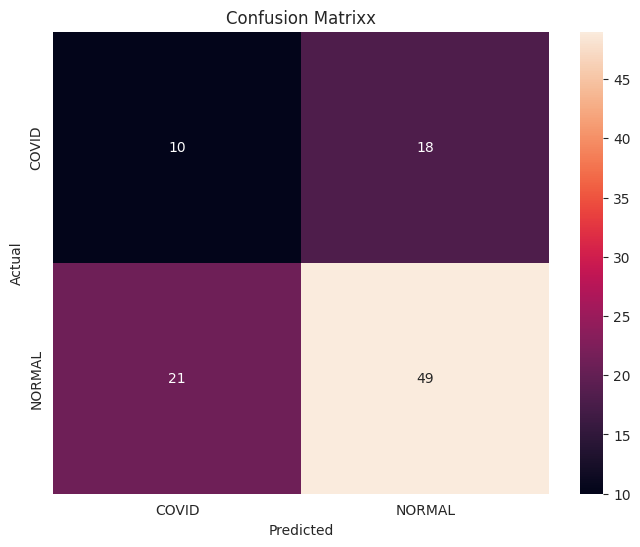

In [45]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()